# PyTorch Implementation of DQN

### Download Requirements and Set the Environment
The following command will download the required scripts and set up the environment. 

In [ ]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
# !pip install -U gym[atari] > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 981 (delta 16), reused 32 (delta 8), pack-reused 931
Receiving objects: 100% (981/981), 3.72 MiB | 29.51 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/ma-gym
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (54.2.0)


In [ ]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Self Note: Agent observation is local coordinate (x,y). 4 actions: Up, down, left, right. Each action taken is an array of both/all 4 agent's action.

In [ ]:
env = wrap_env(gym.make("Switch2-v0"))
env.reset()
obs, reward, done, info = env.step(env.action_space.sample())
print(env.action_space.sample())

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[4, 4]


#### Example of playing Switch2-v0 Using Random Policy

In [ ]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
while not all(done_n):
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
    ep_reward += sum(reward_n)
    env.render()
env.close()
# To improve the training efficiency, render() is not necessary during the training.
# We provide the render and video code here just want to demonstrate how to debugging and analysis.
show_video()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#### Code for Playing Switch2-v0


In [ ]:
# Setup
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# First, create the replay memory of DQN
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))
class MemoryBuffer(object):

  def __init__(self, batch_size):
    self.batch_size = batch_size
    self.memory = deque(maxlen = self.batch_size)
  
  def add_trans(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size, replace = False):
    transitions = np.array(self.memory); length = transitions.shape[0]; idxs = np.arange(length)
    if replace:
      pick_idx = np.random.choice(idxs, size = (batch_size), replace = True)
    else:
      min_size = min(batch_size, length)
      pick_idx = np.random.choice(idxs, size = (min_size), replace = False)

    return transitions[pick_idx]


# # Test
# mem = MemoryBuffer(32)
# env = wrap_env(gym.make("Switch2-v0"))
# env.reset()
# timestep = 1
# curr_obs = env.reset(); action = env.action_space.sample(); agent_idx = 0
# obs_n, reward_n, done_n, info = env.step(action)
# # Append timestep
# curr_obs = np.concatenate([curr_obs, [[timestep], [timestep]]], axis = 1); obs_n_cat = np.concatenate([obs_n, [[timestep+1], [timestep+1]]], axis = 1)
# mem.add_trans(curr_obs[agent_idx], action[agent_idx],  obs_n_cat[agent_idx], reward_n[agent_idx], done_n[agent_idx])
# curr_obs = obs_n; timestep += 1
# for _ in range(10):
#   action = env.action_space.sample()
#   obs_n, reward_n, done_n, info = env.step(action)
#   curr_obs = np.concatenate([curr_obs, [[timestep], [timestep]]], axis = 1); obs_n_cat = np.concatenate([obs_n, [[timestep+1], [timestep+1]]], axis = 1)
#   mem.add_trans(curr_obs[agent_idx], action[agent_idx],  obs_n_cat[agent_idx], reward_n[agent_idx], done_n[agent_idx])
#   curr_obs = obs_n
#   timestep += 1


In [ ]:
# Create the Neural Net to estimate the Q-value
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class DQN(nn.Module):
  # Get all inits from the super class
  def __init__(self, action_dim = 5, state_dim = 3):
    # Q-value would output the action values given a state + the timestep
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(state_dim, 512)
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256,128)
    self.output = nn.Linear(128, action_dim)

  def forward(self, inputs):
    # Get the action values for all actions given that state (as inputs)
    inputs = torch.tensor(inputs, requires_grad = False, dtype = torch.float).to(device)
    out1 = F.relu(self.layer1(inputs))
    out2 = F.relu(self.layer2(out1))
    out3 = F.relu(self.layer3(out2))
    outputs = self.output(out3)
    return outputs

# # Tests
# # Take note: Must move model to cuda, and must move back to cpu, detach, and then convert to numpy. Input size must be batch_size x input dim, where input dim is state_dim
# model = DQN().to(device)
# inputs = torch.tensor(np.random.normal(0.0, 1.0, size = (100, 3)), dtype = torch.float)
# outputs = model.forward(inputs)
# outputs = outputs.cpu().detach().numpy()
# print(outputs.shape)

cuda


In [ ]:
# Create agent class
def epsilon_greedy_action(q_values, epsilon):
  roll = np.random.uniform()
  if roll < epsilon:
    return np.random.randint(0, q_values.shape[0])
  else:
    valid_idx = np.where(q_values == np.max(q_values))[0]
    return np.random.choice(valid_idx)

class SwitchAgent(object):
  def __init__(self, action_dim = 5, state_dim = 3,learn_rate = 0.1, discount = 0.99, target_upd = 0.1, epsilon = 0.2, buffer_size = int(1e5), batch_size = 2048):
    self.timestep = 1
    self.gamma = discount
    self.tau = target_upd
    self.eps = epsilon
    self.target_q = DQN(action_dim, state_dim).to(device)
    self.policy_q = DQN(action_dim, state_dim).to(device)
    self.membuffer = MemoryBuffer(buffer_size)
    self.batch_size = batch_size
    self.optimizer = torch.optim.Adam(self.policy_q.parameters(), lr = learn_rate)
    # self.optimizer = torch.optim.RMSprop(self.policy_q.parameters(), lr = learn_rate)
    self.loss = torch.nn.MSELoss()

    return None

  def take_action(self, obs, explore, eps = None):
    # obs contain the state observations as well as the timestep
    inputs = torch.tensor(obs, dtype = torch.float).to(device)
    q_values = self.policy_q.forward(inputs).cpu().detach().numpy().reshape(-1)
    # self.eps = 1 / np.sqrt(self.timestep)
    if eps is None:
      self.eps = np.exp(-np.sqrt(self.timestep) * 0.01)
    else:
      self.eps = eps
    if explore:
      action = epsilon_greedy_action(q_values, self.eps)
    else:
      valid_actions = np.where(q_values == np.max(q_values))[0]
      action = np.random.choice(valid_actions)
    
    self.timestep += 1
    return action

  def update_target_params(self):
    for target_param, policy_param in zip(self.target_q.parameters(), self.policy_q.parameters()):
      target_param.data.copy_(target_param.data * (1-self.tau) + policy_param.data * self.tau)
    return 0

  def update_policy_q(self):
    # Zero-grad before doing any forward operations, MUST NOT BE AFTER.
    self.optimizer.zero_grad()
    # Update the policy by sampling the stored episodes
    samples = self.membuffer.sample(self.batch_size)

    # Convert to 'columns' of curr_state, curr_action, next_state, reward, and done
    # NOTE: When appending the transitions, make sure to append the timestep to the state. Hence the state is already of length 3
    # NOTE: When appendint the transitions, append only for that agent.
    samples = Transition(*zip(*samples)) # Hence now, the attribute 'state' contains all current states from the batch of transitions, and so on

    # Seperate them to tensors for ease of 'target' computation
    curr_state = torch.tensor(samples.state, dtype = torch.float).to(device)
    next_state = torch.tensor(samples.next_state, dtype = torch.float).to(device)
    rewards = torch.tensor(samples.reward, dtype = torch.float).to(device)
    dones = torch.tensor(samples.done).to(device)
    actions = torch.tensor(samples.action, dtype = torch.int64).to(device)

    # Compute the target
    q_targets = self.target_q.forward(next_state).detach()
    target_val = rewards.view(-1,1) + self.gamma * torch.amax(q_targets, axis = 1).view(-1,1) * torch.logical_not(dones).view(-1,1)

    # Compute policy q output, take only those on the actions taken
    policy_q_val = self.policy_q.forward(curr_state)
    q_val_acts = torch.gather(policy_q_val, 1, actions.view(-1,1)).view(-1, 1)

    # Compute loss
    loss = self.loss(q_val_acts, target_val)

    # Backprop
    loss.backward()
    self.optimizer.step()

    return None



In [ ]:
# Training code
def train_agents(agents, episodes, env):
  cumul_reward_per_episode = []; goals_reached_per_episode = []
  num_agents = len(agents)

  # Reset agent timesteps
  for agent in agents:
    agent.timestep = 1

  for ep in range(episodes):
    ep_timestep = 1
    print(f"Episode {ep+1}")

    # Episode statistics
    total_reward_per_ep = 0; reached_goal = np.zeros(num_agents);

    # Begin episode
    curr_state = env.reset()
    all_done = False

    while not all_done:
      ep_count = ep + 1
      ep_epsilon = min(1, 1.5 / (ep_count ** (1/3)))
      # Per episode statistics

      # Take action for each agent
      action_taken = []; 
      for i in range(num_agents):
        cur_agent = agents[i]
        obs = [curr_state[i][0], curr_state[i][1], ep_timestep]
        # action_taken.append(cur_agent.take_action(obs, True))
        action_taken.append(cur_agent.take_action(obs, True, ep_epsilon))
      
      # Step through the environment
      next_state, reward_n, done_n, info = env.step(action_taken)

      # Store the transition to memory
      for i in range(num_agents):
        if reward_n[i] == 5:
          reached_goal[i] = 1
        
        cur_agent = agents[i]
        # When storing, store the joint reward so the agent acts cooperatively
        # Also, store obs, next_obs, action of the agent ONLY
        # Finally, here, timestep of the agent would have incremented by 1, hence cur_state must be at timestep-1
        obs = [curr_state[i][0], curr_state[i][1], ep_timestep]
        action = action_taken[i]
        next_obs = [next_state[i][0], next_state[i][1], ep_timestep + 1]
        reward = np.sum(reward_n)
        done = done_n[i]
        cur_agent.membuffer.add_trans(obs, action, next_obs, reward, done)

        # perform agent update if the length of the memory already exceeds agent batchsize?
        if len(cur_agent.membuffer.memory) >= cur_agent.batch_size:
          cur_agent.update_policy_q()
          cur_agent.update_target_params()

      curr_state = next_state
      ep_timestep += 1
        

        
      # Store all information needed to plot
      total_reward_per_ep += np.sum(reward_n)

      # update all_done
      all_done = np.all(done_n)

    print(f"Cumul reward {total_reward_per_ep}, Goal reached {np.sum(reached_goal)}")
    cumul_reward_per_episode.append(total_reward_per_ep)
    goals_reached_per_episode.append(np.sum(reached_goal))

    # if np.sum(reached_goal) >= 1:
    #   show_video()

  env.close()
  return cumul_reward_per_episode, goals_reached_per_episode

def test_agents(agents, env):
  num_agents = len(agents)
  agent_rewards = dict(); goal_reached = np.zeros((num_agents))
  for i in range(num_agents):
    agent_rewards[i] = []
  all_done = False
  curr_state = env.reset(); ep_timestep = 1; epsil = 0
  while not all_done:
    action_taken = []
    for i in range(num_agents):
        cur_agent = agents[i]
        obs = [curr_state[i][0], curr_state[i][1], ep_timestep]
        action_taken.append(cur_agent.take_action(obs, False, 0))

    next_state, reward_n, done_n, info = env.step(action_taken)

    # Store reward received and when the goal is reached
    for i in range(num_agents):
      agent_rewards[i].append(reward_n[i])
      if reward_n[i] == 5:
        goal_reached[i] = ep_timestep

    # Transition to next step
    ep_timestep += 1
    curr_state = next_state

    all_done = np.all(done_n)

  return agent_rewards, goal_reached
    

In [ ]:
# Test training for a few episodes
env = wrap_env(gym.make("Switch2-v0"))
num_agents = 2
max_eps = 1000
buffer_size = 5000
discount = 0.95
eps = 1
learning_rate = 2e-4
batchsize = 64
tau = 0.01
agentsS2 = [SwitchAgent(learn_rate = learning_rate, discount = discount, 
                      target_upd = tau, epsilon = eps, buffer_size = buffer_size, batch_size = batchsize) for _ in range(num_agents)]
cumul_rew, goal_reached = train_agents(agentsS2, max_eps, env)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 1
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.999999999999996, Goal reached 0.0
Episode 3
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 4
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 5
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 6
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 7
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 8
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.999999999999996, Goal reached 0.0
Episode 10
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 11
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 12
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 13
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 14
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 15
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 16
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 17
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 18
Cumul reward -4.900000000000006, Goal reached 1.0
Episode 19
Cumul reward -4.900000000000006, Goal reached 1.0
Episode 20
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 21
Cumul reward 1.0, Goal reached 2.0
Episode 22
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 23
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 24
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 25
Cumul reward -9.999999999999996, Goal r

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.999999999999996, Goal reached 0.0
Episode 29
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 30
Cumul reward 3.1999999999999997, Goal reached 2.0
Episode 31
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 32
Cumul reward -4.900000000000006, Goal reached 1.0
Episode 33
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 34
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 35
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 36
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 37
Cumul reward 2.8, Goal reached 2.0
Episode 38
Cumul reward -4.899999999999997, Goal reached 1.0
Episode 39
Cumul reward 4.199999999999999, Goal reached 2.0
Episode 40
Cumul reward 0.9999999999999982, Goal reached 2.0
Episode 41
Cumul reward -4.900000000000004, Goal reached 1.0
Episode 42
Cumul reward 0.19999999999999662, Goal reached 2.0
Episode 43
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 44
Cumul reward -4.900000000000006, Goal r

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.999999999999996, Goal reached 0.0
Episode 66
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 67
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 68
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 69
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 70
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 71
Cumul reward -4.900000000000004, Goal reached 1.0
Episode 72
Cumul reward -4.900000000000004, Goal reached 1.0
Episode 73
Cumul reward 2.599999999999997, Goal reached 2.0
Episode 74
Cumul reward 5.200000000000001, Goal reached 2.0
Episode 75
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 76
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 77
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 78
Cumul reward 1.399999999999999, Goal reached 2.0
Episode 79
Cumul reward 0.5999999999999952, Goal reached 2.0
Episode 80
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 81
Cumul reward -4.89999999999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward 3.5999999999999996, Goal reached 2.0
Episode 127
Cumul reward -4.900000000000006, Goal reached 1.0
Episode 128
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 129
Cumul reward 5.799999999999999, Goal reached 2.0
Episode 130
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 131
Cumul reward 2.5999999999999996, Goal reached 2.0
Episode 132
Cumul reward 1.799999999999999, Goal reached 2.0
Episode 133
Cumul reward -4.900000000000004, Goal reached 1.0
Episode 134
Cumul reward 0.9999999999999964, Goal reached 2.0
Episode 135
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 136
Cumul reward 5.000000000000001, Goal reached 2.0
Episode 137
Cumul reward 2.3999999999999995, Goal reached 2.0
Episode 138
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 139
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 140
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 141
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 142
Cumul rewar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -4.900000000000004, Goal reached 1.0
Episode 218
Cumul reward 3.0, Goal reached 2.0
Episode 219
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 220
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 221
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 222
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 223
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 224
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 225
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 226
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 227
Cumul reward -4.900000000000006, Goal reached 1.0
Episode 228
Cumul reward -4.899999999999997, Goal reached 1.0
Episode 229
Cumul reward 1.9999999999999996, Goal reached 2.0
Episode 230
Cumul reward -4.900000000000001, Goal reached 1.0
Episode 231
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 232
Cumul reward -4.900000000000002, Goal reached 1.0
Episode 233
Cumul reward -4.9000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward 6.6, Goal reached 2.0
Episode 345
Cumul reward 5.800000000000001, Goal reached 2.0
Episode 346
Cumul reward 6.8, Goal reached 2.0
Episode 347
Cumul reward 6.799999999999999, Goal reached 2.0
Episode 348
Cumul reward 6.6, Goal reached 2.0
Episode 349
Cumul reward 5.999999999999999, Goal reached 2.0
Episode 350
Cumul reward 6.4, Goal reached 2.0
Episode 351
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 352
Cumul reward 6.4, Goal reached 2.0
Episode 353
Cumul reward 6.0, Goal reached 2.0
Episode 354
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 355
Cumul reward 1.399999999999996, Goal reached 2.0
Episode 356
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 357
Cumul reward -4.900000000000005, Goal reached 1.0
Episode 358
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 359
Cumul reward 7.0, Goal reached 2.0
Episode 360
Cumul reward -9.999999999999996, Goal reached 0.0
Episode 361
Cumul reward 6.799999999999999, Goal reached 2.0
Episod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward 6.6, Goal reached 2.0
Episode 514
Cumul reward 6.3999999999999995, Goal reached 2.0
Episode 515
Cumul reward 7.199999999999999, Goal reached 2.0
Episode 516
Cumul reward 6.3999999999999995, Goal reached 2.0
Episode 517
Cumul reward 5.3999999999999995, Goal reached 2.0
Episode 518
Cumul reward 6.6, Goal reached 2.0
Episode 519
Cumul reward 6.6, Goal reached 2.0
Episode 520
Cumul reward 7.0, Goal reached 2.0
Episode 521
Cumul reward 7.0, Goal reached 2.0
Episode 522
Cumul reward 6.799999999999999, Goal reached 2.0
Episode 523
Cumul reward 6.999999999999999, Goal reached 2.0
Episode 524
Cumul reward 5.6000000000000005, Goal reached 2.0
Episode 525
Cumul reward 5.0, Goal reached 2.0
Episode 526
Cumul reward 6.6, Goal reached 2.0
Episode 527
Cumul reward 6.6, Goal reached 2.0
Episode 528
Cumul reward 6.999999999999999, Goal reached 2.0
Episode 529
Cumul reward 6.4, Goal reached 2.0
Episode 530
Cumul reward 6.3999999999999995, Goal reached 2.0
Episode 531
Cumul reward 6.19999999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward 6.2, Goal reached 2.0
Episode 731
Cumul reward -4.900000000000003, Goal reached 1.0
Episode 732
Cumul reward 6.6, Goal reached 2.0
Episode 733
Cumul reward 6.0, Goal reached 2.0
Episode 734
Cumul reward 6.199999999999999, Goal reached 2.0
Episode 735
Cumul reward 5.999999999999999, Goal reached 2.0
Episode 736
Cumul reward 6.2, Goal reached 2.0
Episode 737
Cumul reward 6.8, Goal reached 2.0
Episode 738
Cumul reward 6.3999999999999995, Goal reached 2.0
Episode 739
Cumul reward 6.6, Goal reached 2.0
Episode 740
Cumul reward 6.6, Goal reached 2.0
Episode 741
Cumul reward 5.6000000000000005, Goal reached 2.0
Episode 742
Cumul reward 5.999999999999999, Goal reached 2.0
Episode 743
Cumul reward 6.199999999999999, Goal reached 2.0
Episode 744
Cumul reward 5.999999999999999, Goal reached 2.0
Episode 745
Cumul reward 6.199999999999999, Goal reached 2.0
Episode 746
Cumul reward 6.0, Goal reached 2.0
Episode 747
Cumul reward 6.8, Goal reached 2.0
Episode 748
Cumul reward 6.6, Goal re

Remember to reset the timestep of the agent at the start of every episode, in the training loop.

#### Plot the Learning Curve

In [ ]:
def plot_curve(y_data, title, ylabel):
  plt.figure(figsize = (10,8))
  plt.plot((1 + np.arange(len(y_data))), y_data)
  plt.xlabel('Episodes')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid()

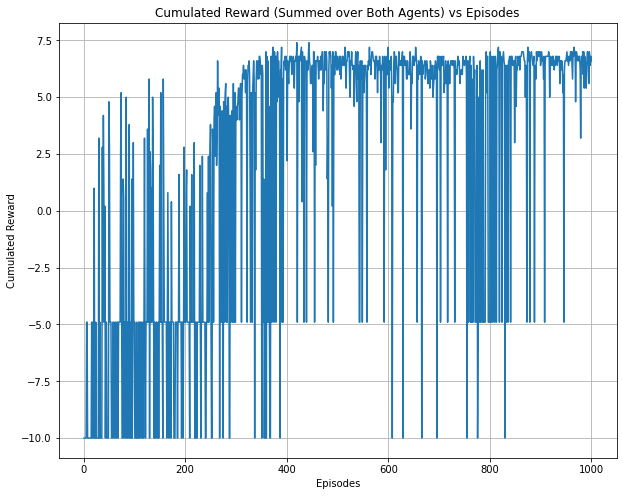

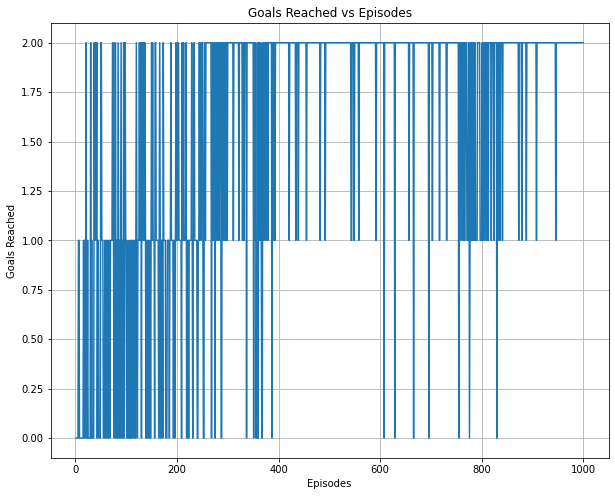

In [ ]:
# Trial 1. Plots (TODO)
plot_curve(cumul_rew, 'Cumulated Reward (Summed over Both Agents) vs Episodes', 'Cumulated Reward')
plot_curve(goal_reached, 'Goals Reached vs Episodes', 'Goals Reached')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Agent 1 reached the goal in 16 steps during test time
Cumulated reward for this agent is 3.5
Agent 2 reached the goal in 7 steps during test time
Cumulated reward for this agent is 3.5


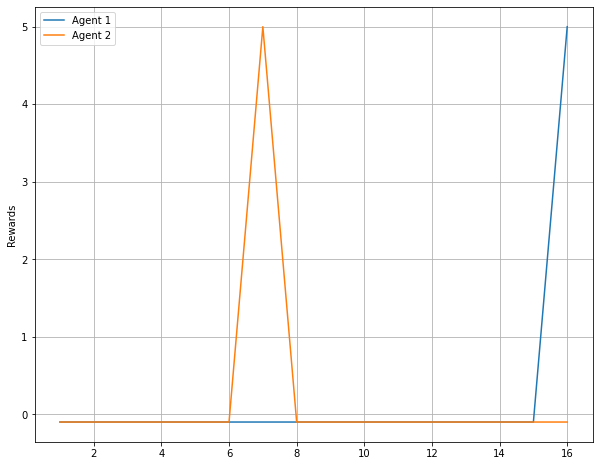

In [ ]:
# Test time
def plot_test_curve(n_agents, rewards, title, ylabel):
  plt.figure(figsize = (10,8)); timesteps = len(rewards[0])
  for i in range(n_agents):
    plt.plot(1 + np.arange(timesteps), rewards[i], label = "Agent "+ str(i+1))
  plt.legend()
  plt.grid()
  plt.ylabel(ylabel)
  return None

rewards, goals = test_agents(agentsS2, env)
plot_test_curve(2, rewards, 'Rewards vs Timesteps in one Episode', 'Rewards')
for i in range(goals.shape[0]):
  print(f"Agent {i+1} reached the goal in {int(goals[i])} steps during test time")
  print(f"Cumulated reward for this agent is {np.sum(rewards[i])}")

#### Analysis on performance

#### Code for Playing Switch4-v0


In [ ]:
# Test training for a few episodes
env = wrap_env(gym.make("Switch4-v0"))
num_agents = 4
max_eps = 1000
buffer_size = 5000
discount = 0.95
eps = 1
learning_rate = 2e-4
batchsize = 256
tau = 0.01
agents = [SwitchAgent(learn_rate = learning_rate, discount = discount, 
                      target_upd = tau, epsilon = eps, buffer_size = buffer_size, batch_size = batchsize) for _ in range(num_agents)]
cumul_rew2, goal_reached2 = train_agents(agents, max_eps, env)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Cumul reward -14.900000000000004, Goal reached 1.0
Episode 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Cumul reward -14.900000000000011, Goal reached 1.0
Episode 3
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 4
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 5
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -19.999999999999993, Goal reached 0.0
Episode 7
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 8
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -19.999999999999993, Goal reached 0.0
Episode 10
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 11
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 12
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 13
Cumul reward -9.800000000000008, Goal reached 2.0
Episode 14
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 15
Cumul reward -14.900000000000013, Goal reached 1.0
Episode 16
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 17
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 18
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 19
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 20
Cumul reward -14.90000000000001, Goal reached 1.0
Episode 21
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 22
Cumul reward -14.899999999999999, Goal reached 1.0
Episode 23
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 24
Cumul reward -9.80000000000001, Goal reached 2.0
Episode 25
Cumul reward

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.800000000000006, Goal reached 2.0
Episode 29
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 30
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 31
Cumul reward -9.80000000000001, Goal reached 2.0
Episode 32
Cumul reward -9.800000000000011, Goal reached 2.0
Episode 33
Cumul reward -9.80000000000001, Goal reached 2.0
Episode 34
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 35
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 36
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 37
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 38
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 39
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 40
Cumul reward -14.899999999999997, Goal reached 1.0
Episode 41
Cumul reward -4.7, Goal reached 3.0
Episode 42
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 43
Cumul reward -9.80000000000001, Goal reached 2.0
Episode 44
Cumul reward -14.9, Goal reache

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.800000000000002, Goal reached 2.0
Episode 66
Cumul reward -4.699999999999998, Goal reached 3.0
Episode 67
Cumul reward -9.800000000000008, Goal reached 2.0
Episode 68
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 69
Cumul reward 0.399999999999995, Goal reached 4.0
Episode 70
Cumul reward -4.700000000000007, Goal reached 3.0
Episode 71
Cumul reward -14.90000000000001, Goal reached 1.0
Episode 72
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 73
Cumul reward -9.800000000000008, Goal reached 2.0
Episode 74
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 75
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 76
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 77
Cumul reward -4.6999999999999975, Goal reached 3.0
Episode 78
Cumul reward -14.90000000000001, Goal reached 1.0
Episode 79
Cumul reward -14.900000000000007, Goal reached 1.0
Episode 80
Cumul reward -9.800000000000004, Goal reached 2.0
Episode 81
Cumul reward -4.70

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -9.800000000000002, Goal reached 2.0
Episode 127
Cumul reward -4.7, Goal reached 3.0
Episode 128
Cumul reward -4.7000000000000055, Goal reached 3.0
Episode 129
Cumul reward -9.80000000000001, Goal reached 2.0
Episode 130
Cumul reward 1.2000000000000015, Goal reached 4.0
Episode 131
Cumul reward -4.6999999999999975, Goal reached 3.0
Episode 132
Cumul reward -9.800000000000002, Goal reached 2.0
Episode 133
Cumul reward -9.800000000000004, Goal reached 2.0
Episode 134
Cumul reward -4.7, Goal reached 3.0
Episode 135
Cumul reward -4.700000000000001, Goal reached 3.0
Episode 136
Cumul reward -14.900000000000007, Goal reached 1.0
Episode 137
Cumul reward -4.700000000000002, Goal reached 3.0
Episode 138
Cumul reward -4.699999999999999, Goal reached 3.0
Episode 139
Cumul reward 6.400000000000003, Goal reached 4.0
Episode 140
Cumul reward -4.700000000000001, Goal reached 3.0
Episode 141
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 142
Cumul reward -9.800000000000004, G

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward 0.400000000000003, Goal reached 4.0
Episode 218
Cumul reward -9.800000000000006, Goal reached 2.0
Episode 219
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 220
Cumul reward -4.699999999999998, Goal reached 3.0
Episode 221
Cumul reward 1.6000000000000023, Goal reached 4.0
Episode 222
Cumul reward 11.600000000000001, Goal reached 4.0
Episode 223
Cumul reward 10.4, Goal reached 4.0
Episode 224
Cumul reward -4.700000000000001, Goal reached 3.0
Episode 225
Cumul reward 9.600000000000001, Goal reached 4.0
Episode 226
Cumul reward 10.000000000000004, Goal reached 4.0
Episode 227
Cumul reward -4.700000000000003, Goal reached 3.0
Episode 228
Cumul reward 10.400000000000002, Goal reached 4.0
Episode 229
Cumul reward 7.600000000000001, Goal reached 4.0
Episode 230
Cumul reward 6.8000000000000025, Goal reached 4.0
Episode 231
Cumul reward -9.800000000000008, Goal reached 2.0
Episode 232
Cumul reward 7.200000000000001, Goal reached 4.0
Episode 233
Cumul reward 8.4000000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -14.900000000000007, Goal reached 1.0
Episode 345
Cumul reward 9.6, Goal reached 4.0
Episode 346
Cumul reward 1.1999999999999988, Goal reached 4.0
Episode 347
Cumul reward 10.399999999999999, Goal reached 4.0
Episode 348
Cumul reward 11.200000000000003, Goal reached 4.0
Episode 349
Cumul reward -4.7, Goal reached 3.0
Episode 350
Cumul reward 6.799999999999999, Goal reached 4.0
Episode 351
Cumul reward -4.700000000000002, Goal reached 3.0
Episode 352
Cumul reward 10.0, Goal reached 4.0
Episode 353
Cumul reward 10.8, Goal reached 4.0
Episode 354
Cumul reward 10.0, Goal reached 4.0
Episode 355
Cumul reward 11.200000000000001, Goal reached 4.0
Episode 356
Cumul reward 10.8, Goal reached 4.0
Episode 357
Cumul reward 6.400000000000001, Goal reached 4.0
Episode 358
Cumul reward -4.700000000000001, Goal reached 3.0
Episode 359
Cumul reward 9.200000000000003, Goal reached 4.0
Episode 360
Cumul reward -14.900000000000007, Goal reached 1.0
Episode 361
Cumul reward 9.600000000000001, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward -4.699999999999999, Goal reached 3.0
Episode 514
Cumul reward -9.800000000000006, Goal reached 2.0
Episode 515
Cumul reward 7.199999999999999, Goal reached 4.0
Episode 516
Cumul reward 3.1999999999999993, Goal reached 4.0
Episode 517
Cumul reward 3.199999999999999, Goal reached 4.0
Episode 518
Cumul reward 9.600000000000001, Goal reached 4.0
Episode 519
Cumul reward -9.80000000000001, Goal reached 2.0
Episode 520
Cumul reward 10.400000000000002, Goal reached 4.0
Episode 521
Cumul reward 6.3999999999999995, Goal reached 4.0
Episode 522
Cumul reward -9.800000000000002, Goal reached 2.0
Episode 523
Cumul reward -14.900000000000007, Goal reached 1.0
Episode 524
Cumul reward -4.699999999999998, Goal reached 3.0
Episode 525
Cumul reward -14.900000000000007, Goal reached 1.0
Episode 526
Cumul reward 9.600000000000001, Goal reached 4.0
Episode 527
Cumul reward 8.4, Goal reached 4.0
Episode 528
Cumul reward -9.800000000000002, Goal reached 2.0
Episode 529
Cumul reward 4.00000000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Cumul reward 10.0, Goal reached 4.0
Episode 731
Cumul reward 2.8000000000000025, Goal reached 4.0
Episode 732
Cumul reward 8.4, Goal reached 4.0
Episode 733
Cumul reward -4.699999999999998, Goal reached 3.0
Episode 734
Cumul reward -4.699999999999998, Goal reached 3.0
Episode 735
Cumul reward 10.0, Goal reached 4.0
Episode 736
Cumul reward 9.600000000000001, Goal reached 4.0
Episode 737
Cumul reward 10.4, Goal reached 4.0
Episode 738
Cumul reward 10.4, Goal reached 4.0
Episode 739
Cumul reward -14.900000000000011, Goal reached 1.0
Episode 740
Cumul reward 6.0000000000000036, Goal reached 4.0
Episode 741
Cumul reward 10.4, Goal reached 4.0
Episode 742
Cumul reward 10.0, Goal reached 4.0
Episode 743
Cumul reward -19.999999999999993, Goal reached 0.0
Episode 744
Cumul reward 9.2, Goal reached 4.0
Episode 745
Cumul reward -9.800000000000006, Goal reached 2.0
Episode 746
Cumul reward 10.0, Goal reached 4.0
Episode 747
Cumul reward 9.200000000000003, Goal reached 4.0
Episode 748
Cumul reward

#### Plot the Learning Curve

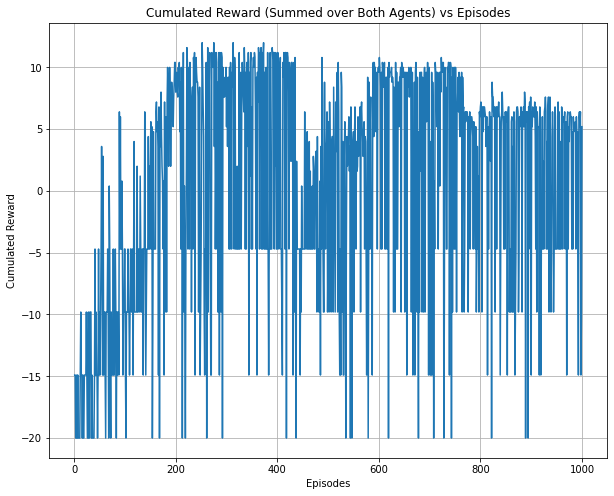

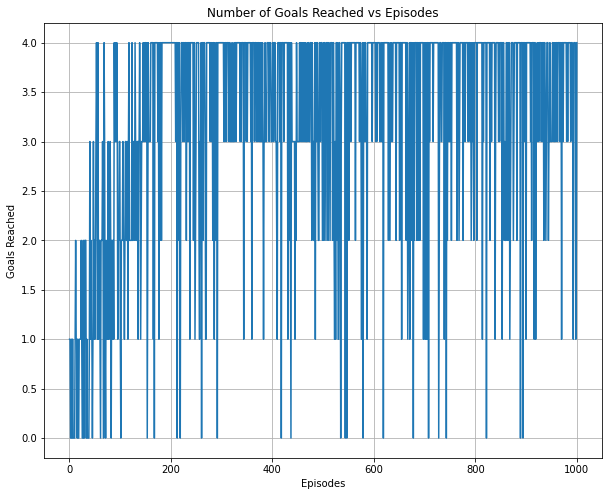

In [ ]:
plot_curve(cumul_rew2, 'Cumulated Reward (Summed over Both Agents) vs Episodes', 'Cumulated Reward')
plot_curve(goal_reached2, 'Number of Goals Reached vs Episodes', 'Goals Reached')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Agent 1 reached the goal in 27 steps during test time
Agent 2 reached the goal in 35 steps during test time
Agent 3 reached the goal in 22 steps during test time
Agent 4 reached the goal in 9 steps during test time


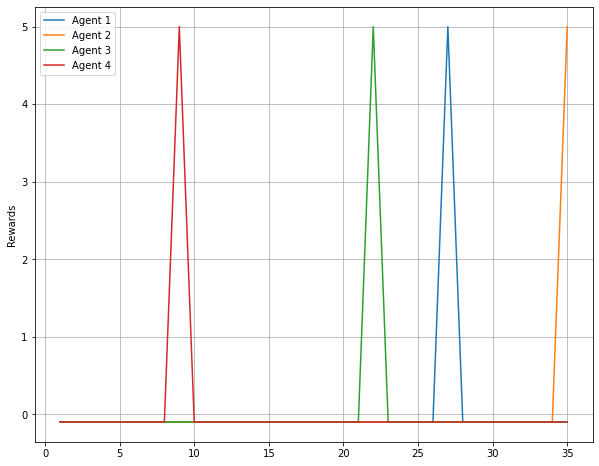

In [ ]:
# Test time
def plot_test_curve(n_agents, rewards, title, ylabel):
  plt.figure(figsize = (10,8)); timesteps = len(rewards[0])
  for i in range(n_agents):
    plt.plot(1 + np.arange(timesteps), rewards[i], label = "Agent "+ str(i+1))
  plt.legend()
  plt.grid()
  plt.ylabel(ylabel)
  return None


rewards, goals = test_agents(agents, env)
plot_test_curve(4, rewards, 'Rewards vs Timesteps in one Episode', 'Rewards')
for i in range(goals.shape[0]):
  print(f"Agent {i+1} reached the goal in {int(goals[i])} steps during test time")